In [67]:
import os
import re
import pickle
import pandas as pd
import numpy as np
import textwrap
import torch
from accelerate import init_empty_weights, Accelerator
from transformers import AutoModelForCausalLM, AutoTokenizer
from custom_modeling_opt import CustomOPTForCausalLM
from matplotlib import pyplot as plt

In [2]:
seed_value=42
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
import rdkit.Chem as Chem
import sys
from rdkit.Chem import RDConfig, MACCSkeys, QED
from rdkit.Chem.rdMolDescriptors import CalcTPSA, CalcCrippenDescriptors
from rdkit.Chem import Descriptors
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

In [4]:
device = "cuda:1"

In [5]:
tokenizer = AutoTokenizer.from_pretrained("/auto/home/menuab/code/ChemLacticaTestSuite/src/tokenizer/ChemLacticaTokenizer_50066/")
print('tokenizer size: ', len(tokenizer))

tokenizer size:  50066


In [6]:
checkpoint_path = "/auto/home/menuab/code/checkpoints/f2c6ebb289994595a478f513/125m_126k_f2c6/"
checkpoint_path = "/auto/home/menuab/code/checkpoints/f3fbd012918247a388efa732/125m_126k_f3fb/"
checkpoint_path = "/auto/home/menuab/code/checkpoints/26d322857a184fcbafda5d4a/125m_118k_26d3/"
checkpoint_path

'/auto/home/menuab/code/checkpoints/26d322857a184fcbafda5d4a/125m_118k_26d3/'

In [7]:
model = CustomOPTForCausalLM.from_pretrained(
            checkpoint_path,
            use_flash_attn=True,
            torch_dtype=torch.bfloat16
            )
model.eval()
model.to(device)
print(f'model loaded with embedding size of : {model.model.decoder.embed_tokens.num_embeddings}')
assert(model.model.decoder.embed_tokens.num_embeddings == len(tokenizer))

model loaded with embedding size of : 50066


In [9]:
pubchem_stats_file = open("../stats_data/pubchem_stats.pkl", 'rb')
pubchem_stats = pickle.load(pubchem_stats_file)
pubchem_stats_file.close()

In [68]:
pubchem_stats["QED"]

QED
(-0.00095, 0.0095]    0.000729
(0.0095, 0.019]       0.004682
(0.019, 0.0285]       0.008829
(0.0285, 0.038]       0.008861
(0.038, 0.0475]       0.005575
                        ...   
(0.902, 0.912]        0.010948
(0.912, 0.922]        0.008600
(0.922, 0.931]        0.005762
(0.931, 0.94]         0.003715
(0.94, 0.95]          0.000461
Name: count, Length: 100, dtype: float64

In [14]:
frequency_series = pubchem_stats["QED"] 
# Calculate cumulative probabilities:
cumulative_probs = frequency_series.cumsum() / frequency_series.sum()

# Generate 100 random numbers between 0 and 1:
random_numbers = np.random.rand(100)

# Sample values based on cumulative probabilities:
sampled_values = np.interp(random_numbers, cumulative_probs.index, cumulative_probs.values)

print(sampled_values)  # Print the 100 sampled values

TypeError: float() argument must be a string or a real number, not 'pandas._libs.interval.Interval'

In [93]:
frequency_data = pubchem_stats["QED"] 
frequency_data /= frequency_data.sum()
sampled_values = np.random.choice(np.arange(0,1,0.01), size=10000, p=None)

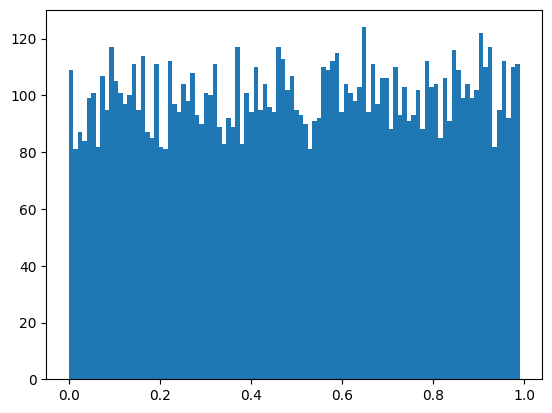

In [94]:
plt.hist(sampled_values, bins=100);